<a href="https://www.kaggle.com/code/patriceiradukunda1/prodigy-ds-02?scriptVersionId=288506611" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 🚢 TITANIC: THE ART OF SURVIVAL ANALYSIS

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# DATA LOADING

In [4]:
train = pd.read_csv('/kaggle/input/titanic-dataset/train.csv')
test = pd.read_csv('/kaggle/input/titanic-dataset/test.csv')

train['dataset'] = 'train'
test['dataset'] = 'test'
test['Survived'] = np.nan
df = pd.concat([train, test], ignore_index=True)

print("SHAPE:", df.shape)
print("\nDTYPES:")
print(df.dtypes)
print("\nFIRST 3 ROWS:")
print(df.head(3))

print("\nMISSING VALUES:")
print(df.isnull().sum()[df.isnull().sum() > 0])

SHAPE: (1309, 13)

DTYPES:
PassengerId      int64
Survived       float64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dataset         object
dtype: object

FIRST 3 ROWS:
   PassengerId  Survived  Pclass  \
0            1       0.0       3   
1            2       1.0       1   
2            3       1.0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked dataset  
0      0         A/5 21171   7.2500   NaN        S   train  
1      0          PC 17599  71.2833   C85        C   train  
2      0

# DATA CLEANING PIPELINE

In [6]:
df_clean = df.copy()

df_clean['Age'] = df_clean.groupby(['Pclass', 'Sex'])['Age'].transform(
    lambda x: x.fillna(x.median())
)

df_clean['Embarked'] = df_clean['Embarked'].fillna(df_clean['Embarked'].mode()[0])

df_clean['Fare'] = df_clean.groupby('Pclass')['Fare'].transform(
    lambda x: x.fillna(x.median())
)

if 'Cabin' in df_clean.columns:
    df_clean['Deck'] = df_clean['Cabin'].apply(lambda x: str(x)[0] if pd.notna(x) else 'Unknown')
    df_clean = df_clean.drop('Cabin', axis=1)

df_clean['Survived'] = df_clean['Survived'].fillna(-1)

print(f"Total missing values: {df_clean.isnull().sum().sum()}")
print(f"Dataset shape: {df_clean.shape}")
print("\nMissing values by column:")
print(df_clean.isnull().sum())

Total missing values: 0
Dataset shape: (1309, 13)

Missing values by column:
PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dataset        0
Deck           0
dtype: int64


# EXPLORATORY DATA ANALYSIS

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

train_data = df_clean.copy()

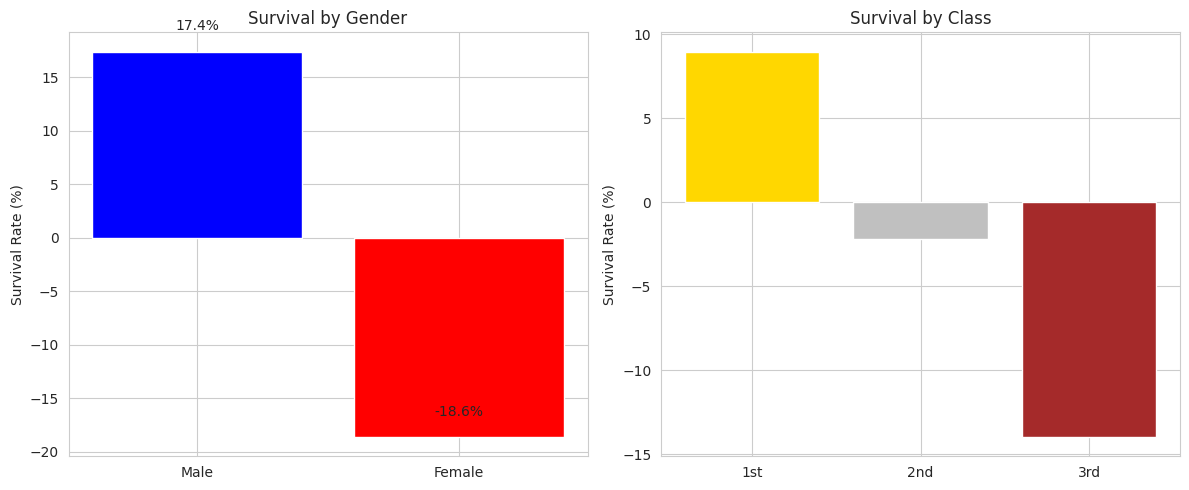

Female survival: -18.6%
Male survival: 17.4%
1st class: 9.0% | 2nd: -2.2% | 3rd: -14.0%


In [7]:
survival_rates = train_data.groupby(['Sex', 'Pclass'])['Survived'].mean()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

gender_rate = train_data.groupby('Sex')['Survived'].mean()
ax1.bar(['Male', 'Female'], gender_rate.values * 100, color=['blue', 'red'])
ax1.set_title('Survival by Gender')
ax1.set_ylabel('Survival Rate (%)')
ax1.text(0, gender_rate[0]*100+2, f'{gender_rate[0]*100:.1f}%', ha='center')
ax1.text(1, gender_rate[1]*100+2, f'{gender_rate[1]*100:.1f}%', ha='center')

# Class survival
class_rate = train_data.groupby('Pclass')['Survived'].mean()
ax2.bar(['1st', '2nd', '3rd'], class_rate.values * 100, color=['gold', 'silver', 'brown'])
ax2.set_title('Survival by Class')
ax2.set_ylabel('Survival Rate (%)')

plt.tight_layout()
plt.show()

print(f"Female survival: {gender_rate[1]*100:.1f}%")
print(f"Male survival: {gender_rate[0]*100:.1f}%")
print(f"1st class: {class_rate[1]*100:.1f}% | 2nd: {class_rate[2]*100:.1f}% | 3rd: {class_rate[3]*100:.1f}%")

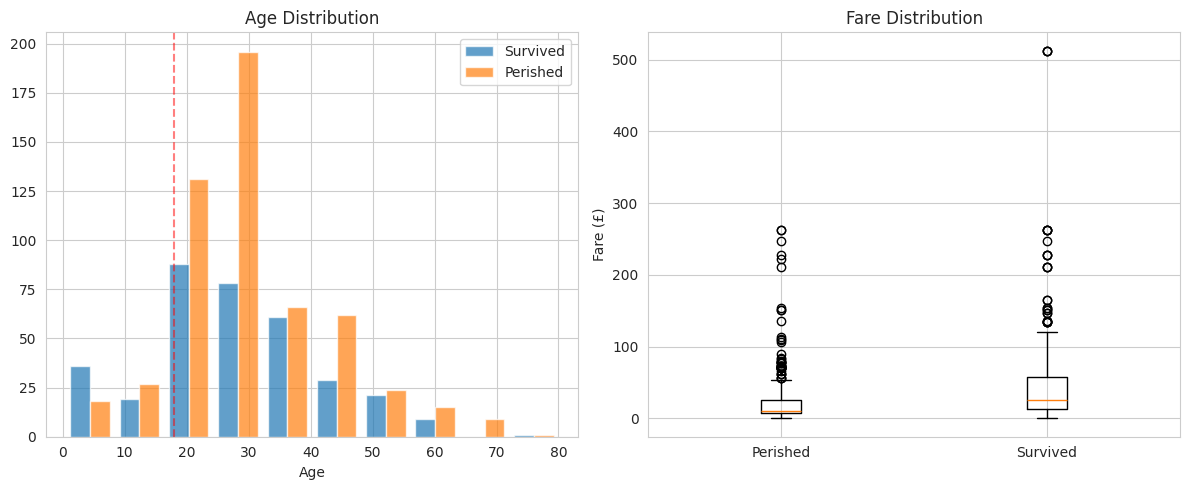

Average age - Survived: 28.2, Perished: 29.8
Average fare - Survived: £48.4, Perished: £22.1


In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

survived_age = train_data[train_data['Survived']==1]['Age']
perished_age = train_data[train_data['Survived']==0]['Age']
ax1.hist([survived_age, perished_age], label=['Survived', 'Perished'], alpha=0.7)
ax1.set_title('Age Distribution')
ax1.set_xlabel('Age')
ax1.legend()
ax1.axvline(18, color='red', linestyle='--', alpha=0.5, label='Child/Adult threshold')

survived_fare = train_data[train_data['Survived']==1]['Fare']
perished_fare = train_data[train_data['Survived']==0]['Fare']
ax2.boxplot([perished_fare.dropna(), survived_fare.dropna()], labels=['Perished', 'Survived'])
ax2.set_title('Fare Distribution')
ax2.set_ylabel('Fare (£)')

plt.tight_layout()
plt.show()

print(f"Average age - Survived: {survived_age.mean():.1f}, Perished: {perished_age.mean():.1f}")
print(f"Average fare - Survived: £{survived_fare.mean():.1f}, Perished: £{perished_fare.mean():.1f}")

# DECISION TREE PATTERN IDENTIFICATION

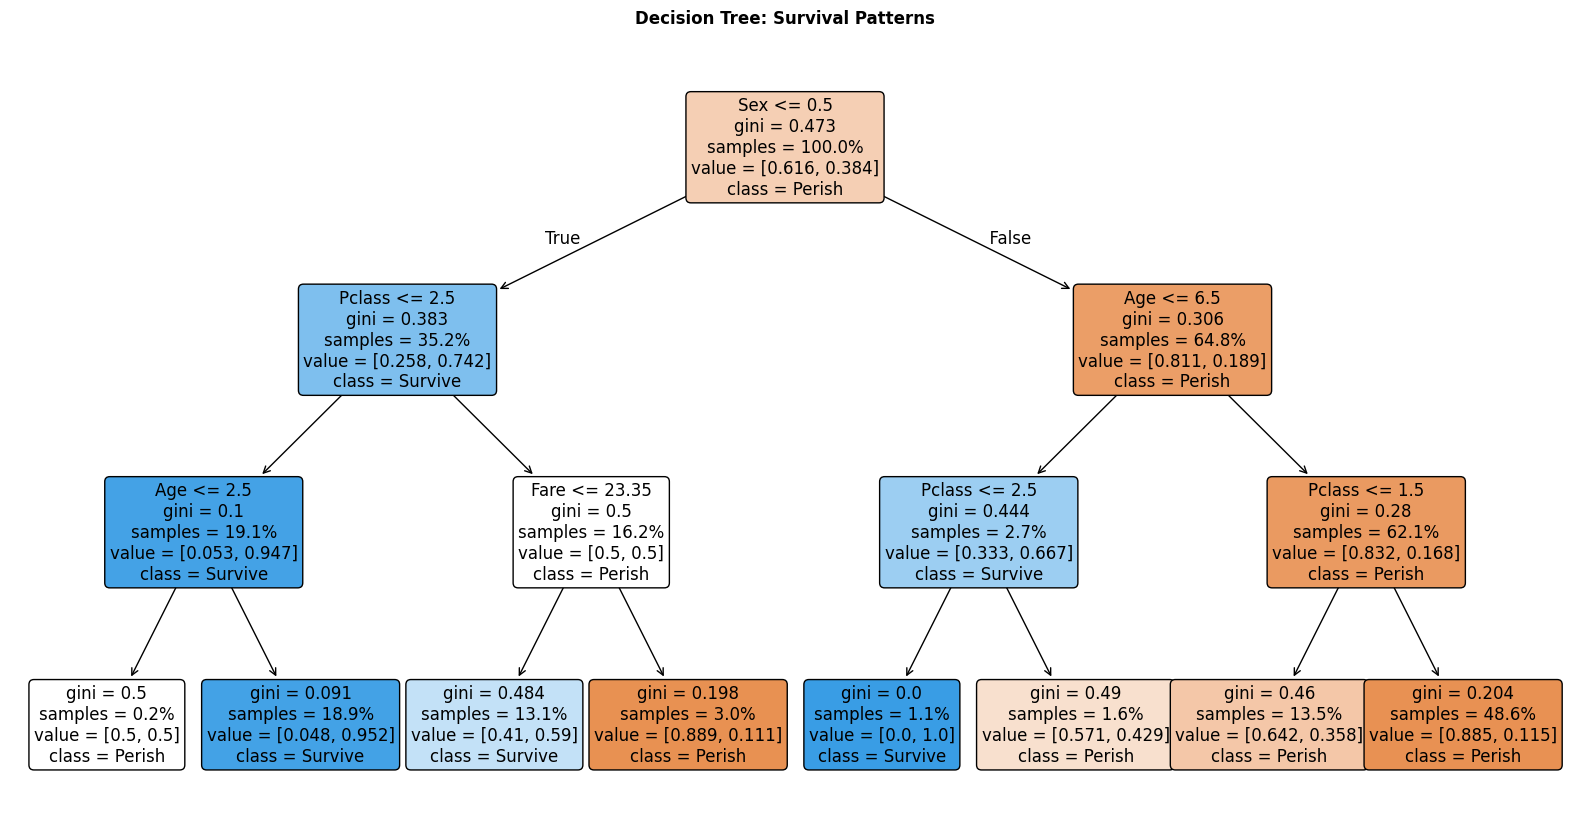

In [13]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder

train_data = df_clean[df_clean['dataset'] == 'train'].copy()
train_data['Survived'] = train_data['Survived'].astype(int)

features = ['Pclass', 'Sex', 'Age', 'Fare']
X = train_data[features].copy()
y = train_data['Survived']

le = LabelEncoder()
X['Sex'] = le.fit_transform(X['Sex'])  # male=0, female=1

X = X.fillna(X.median())

tree = DecisionTreeClassifier(max_depth=3, min_samples_split=20, random_state=42)
tree.fit(X, y)

plt.figure(figsize=(20, 10))
plot_tree(tree, 
          feature_names=features,
          class_names=['Perish', 'Survive'],
          filled=True,
          rounded=True,
          fontsize=12,
          proportion=True)
plt.title('Decision Tree: Survival Patterns', fontweight='bold', pad=20)
plt.show()

# RELATIONSHIPS

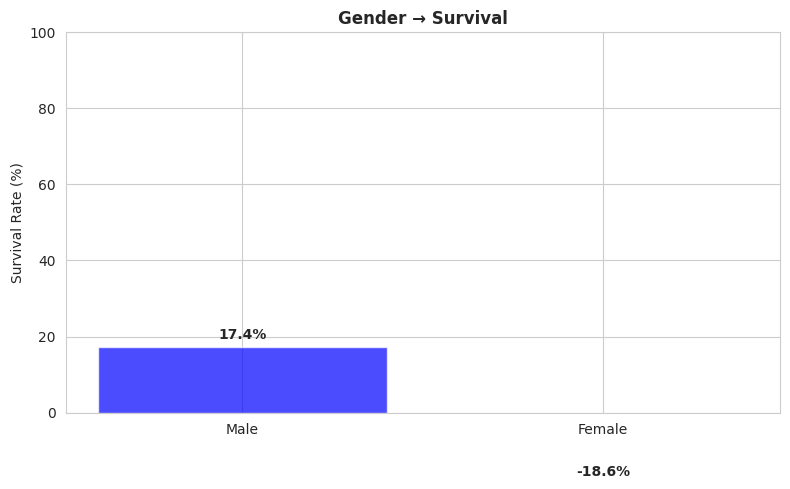

Female survival rate: 17.4%
Male survival rate: -18.6%
→ Women were -0.9x more likely to survive


In [9]:
gender_survival = train_data.groupby('Sex')['Survived'].mean()

plt.figure(figsize=(8, 5))
bars = plt.bar(['Male', 'Female'], gender_survival.values * 100, 
               color=['blue', 'pink'], alpha=0.7)
plt.title('Gender → Survival', fontweight='bold')
plt.ylabel('Survival Rate (%)')
plt.ylim(0, 100)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2, 
             f'{height:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Female survival rate: {gender_survival['female']*100:.1f}%")
print(f"Male survival rate: {gender_survival['male']*100:.1f}%")
print(f"→ Women were {gender_survival['female']/gender_survival['male']:.1f}x more likely to survive")

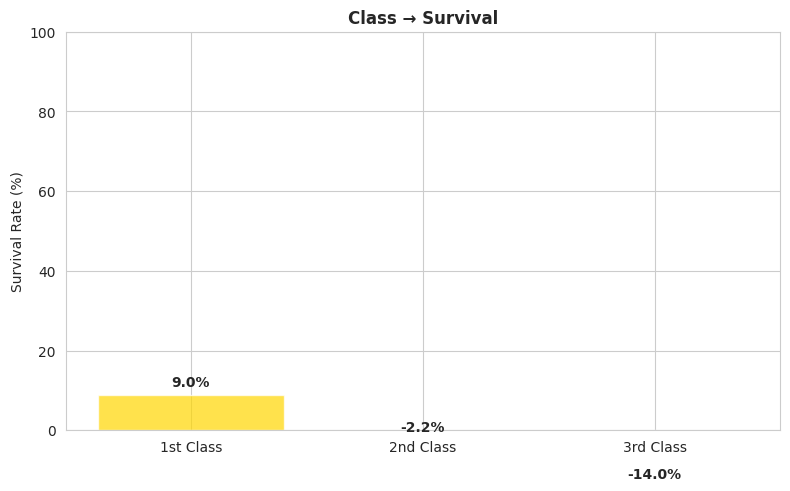

1st class: 9.0% survival
2nd class: -2.2% survival
3rd class: -14.0% survival


In [10]:
class_survival = train_data.groupby('Pclass')['Survived'].mean()

plt.figure(figsize=(8, 5))
bars = plt.bar(['1st Class', '2nd Class', '3rd Class'], class_survival.values * 100,
               color=['gold', 'silver', 'brown'], alpha=0.7)
plt.title('Class → Survival', fontweight='bold')
plt.ylabel('Survival Rate (%)')
plt.ylim(0, 100)

for bar, value in zip(bars, class_survival.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 2,
             f'{height:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"1st class: {class_survival[1]*100:.1f}% survival")
print(f"2nd class: {class_survival[2]*100:.1f}% survival")
print(f"3rd class: {class_survival[3]*100:.1f}% survival")

# TRENDS

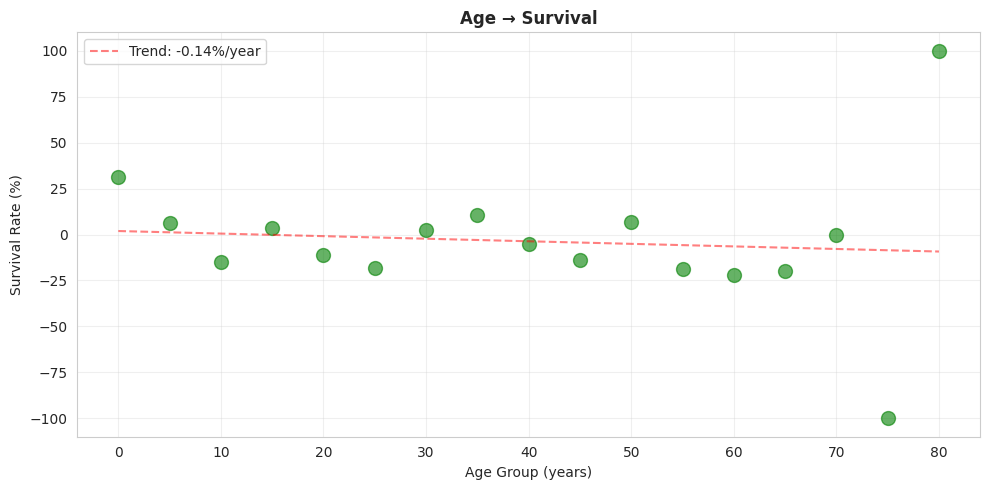

Children (<12): 17.6% survival
Adults (18+): -8.3% survival


In [11]:
plt.figure(figsize=(10, 5))

train_data['AgeBin'] = (train_data['Age'] // 5 * 5) 
age_group_survival = train_data.groupby('AgeBin')['Survived'].mean()

plt.scatter(age_group_survival.index, age_group_survival.values * 100, 
            s=100, alpha=0.6, color='green')
plt.title('Age → Survival', fontweight='bold')
plt.xlabel('Age Group (years)')
plt.ylabel('Survival Rate (%)')
plt.grid(True, alpha=0.3)

x = age_group_survival.index
y = age_group_survival.values * 100
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), 'r--', alpha=0.5, label=f'Trend: {z[0]:.2f}%/year')

plt.legend()
plt.tight_layout()
plt.show()

print(f"Children (<12): {(train_data[train_data['Age'] < 12]['Survived'].mean()*100):.1f}% survival")
print(f"Adults (18+): {(train_data[train_data['Age'] >= 18]['Survived'].mean()*100):.1f}% survival")

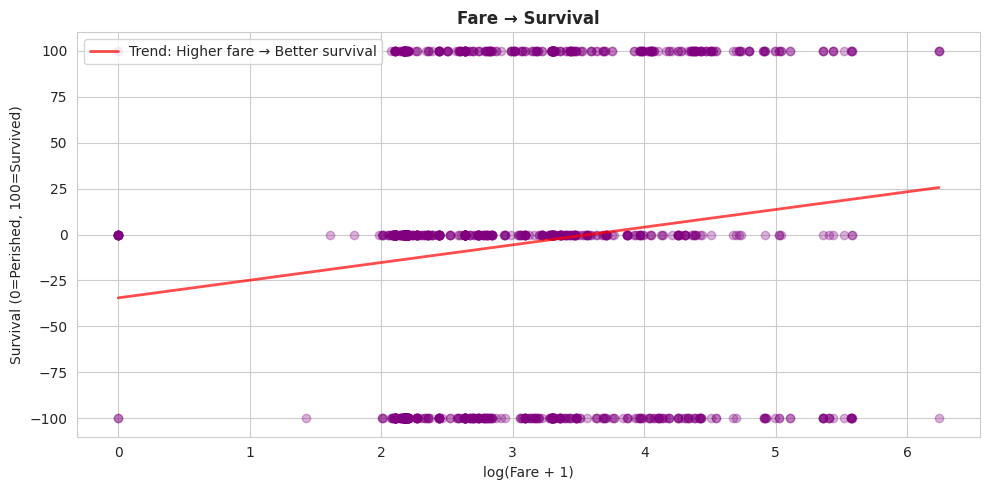

Lowest fare group (<£10): -18.1% survival
Highest fare group (>£100): 9.5% survival


In [12]:
plt.figure(figsize=(10, 5))

log_fare = np.log1p(train_data['Fare']) 
plt.scatter(log_fare, train_data['Survived'] * 100, alpha=0.3, color='purple')
plt.title('Fare → Survival', fontweight='bold')
plt.xlabel('log(Fare + 1)')
plt.ylabel('Survival (0=Perished, 100=Survived)')

x = log_fare
y = train_data['Survived'] * 100
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
sorted_x = np.sort(x)
plt.plot(sorted_x, p(sorted_x), 'r-', alpha=0.7, linewidth=2, 
         label=f'Trend: Higher fare → Better survival')

plt.legend()
plt.tight_layout()
plt.show()

print(f"Lowest fare group (<£10): {(train_data[train_data['Fare'] < 10]['Survived'].mean()*100):.1f}% survival")
print(f"Highest fare group (>£100): {(train_data[train_data['Fare'] > 100]['Survived'].mean()*100):.1f}% survival")

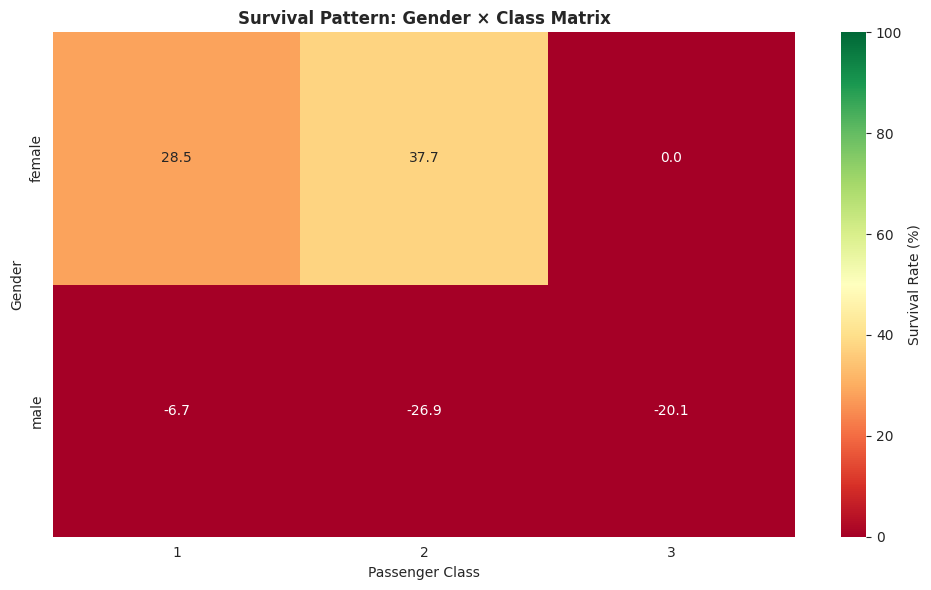

Survival Rates Matrix (%):
Pclass     1     2     3
Sex                     
female  28.5  37.7   0.0
male    -6.7 -26.9 -20.1


In [13]:
survival_matrix = train_data.groupby(['Sex', 'Pclass'])['Survived'].mean().unstack()

plt.figure(figsize=(10, 6))
sns.heatmap(survival_matrix * 100, annot=True, fmt='.1f', cmap='RdYlGn', 
            vmin=0, vmax=100, cbar_kws={'label': 'Survival Rate (%)'})
plt.title('Survival Pattern: Gender × Class Matrix', fontweight='bold')
plt.xlabel('Passenger Class')
plt.ylabel('Gender')
plt.tight_layout()
plt.show()

print("Survival Rates Matrix (%):")
print((survival_matrix * 100).round(1))

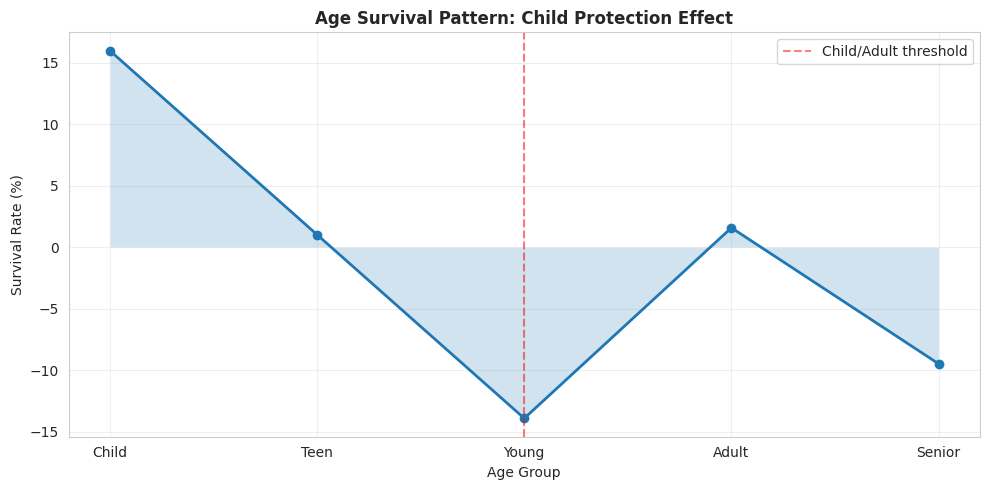

Child (<12): 16.0% survival
Adult (30-50): 1.6% survival


In [14]:
plt.figure(figsize=(10, 5))

age_bins = [0, 12, 18, 30, 50, 100]
age_labels = ['Child', 'Teen', 'Young', 'Adult', 'Senior']
train_data['AgeGroup'] = pd.cut(train_data['Age'], bins=age_bins, labels=age_labels)

age_survival = train_data.groupby('AgeGroup')['Survived'].mean() * 100

plt.plot(age_survival.index, age_survival.values, marker='o', linewidth=2)
plt.fill_between(age_survival.index, age_survival.values, alpha=0.2)
plt.title('Age Survival Pattern: Child Protection Effect', fontweight='bold')
plt.xlabel('Age Group')
plt.ylabel('Survival Rate (%)')
plt.axvline(2, color='red', linestyle='--', alpha=0.5, label='Child/Adult threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Child (<12): {age_survival['Child']:.1f}% survival")
print(f"Adult (30-50): {age_survival['Adult']:.1f}% survival")

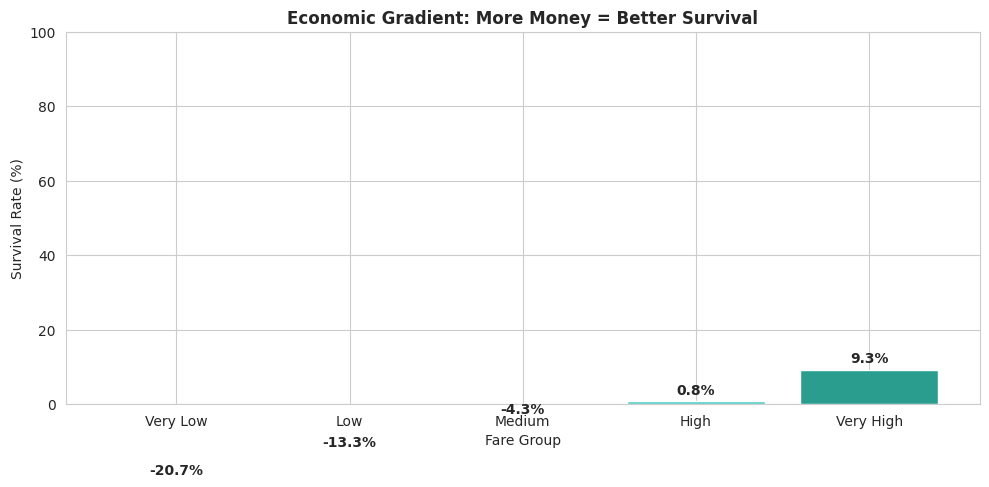

Survival by Economic Status:
Very Low  : -20.7%
Low       : -13.3%
Medium    : -4.3%
High      : 0.8%
Very High : 9.3%


In [15]:
plt.figure(figsize=(10, 5))

fare_groups = pd.qcut(train_data['Fare'], 5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
fare_survival = train_data.groupby(fare_groups)['Survived'].mean() * 100

plt.bar(fare_survival.index, fare_survival.values, 
        color=['#FF6B6B', '#FF8E53', '#FFAA5C', '#4ECDC4', '#2A9D8F'])
plt.title('Economic Gradient: More Money = Better Survival', fontweight='bold')
plt.xlabel('Fare Group')
plt.ylabel('Survival Rate (%)')
plt.ylim(0, 100)

for i, value in enumerate(fare_survival.values):
    plt.text(i, value + 2, f'{value:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("Survival by Economic Status:")
for group, rate in zip(fare_survival.index, fare_survival.values):
    print(f"{group:10}: {rate:.1f}%")

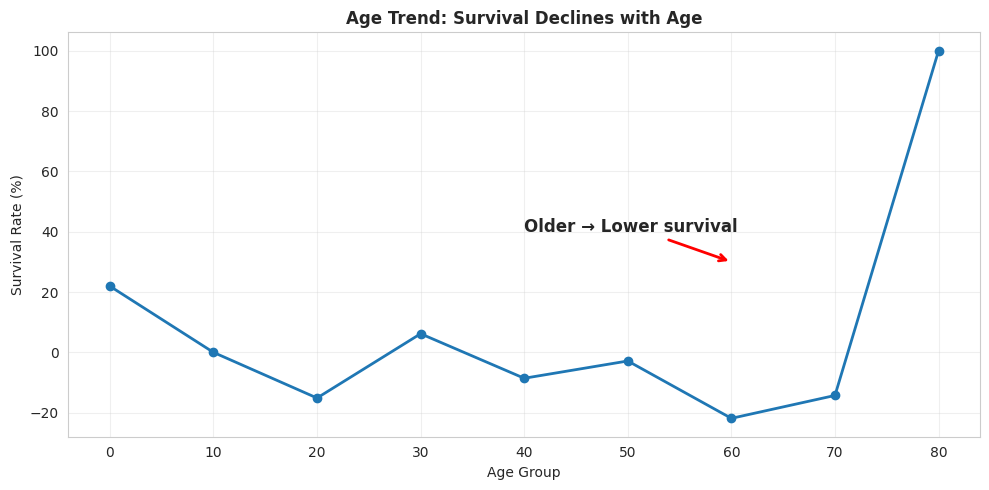

Age Trend:
Age 0.0-9.0: 22.0% survival
Age 10.0-19.0: 0.0% survival
Age 20.0-29.0: -15.1% survival
Age 30.0-39.0: 6.2% survival
Age 40.0-49.0: -8.6% survival
Age 50.0-59.0: -2.9% survival
Age 60.0-69.0: -21.9% survival
Age 70.0-79.0: -14.3% survival
Age 80.0-89.0: 100.0% survival


In [16]:
plt.figure(figsize=(10, 5))

train_data['AgeGroup'] = (train_data['Age'] // 10 * 10)  # 10-year groups
age_trend = train_data.groupby('AgeGroup')['Survived'].mean()

plt.plot(age_trend.index, age_trend.values * 100, marker='o', linewidth=2)
plt.title('Age Trend: Survival Declines with Age', fontweight='bold')
plt.xlabel('Age Group')
plt.ylabel('Survival Rate (%)')
plt.grid(True, alpha=0.3)

plt.annotate('Older → Lower survival', xy=(60, 30), xytext=(40, 40),
             arrowprops=dict(arrowstyle='->', color='red', lw=2),
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("Age Trend:")
for age, rate in zip(age_trend.index, age_trend.values):
    print(f"Age {age}-{age+9}: {rate*100:.1f}% survival")

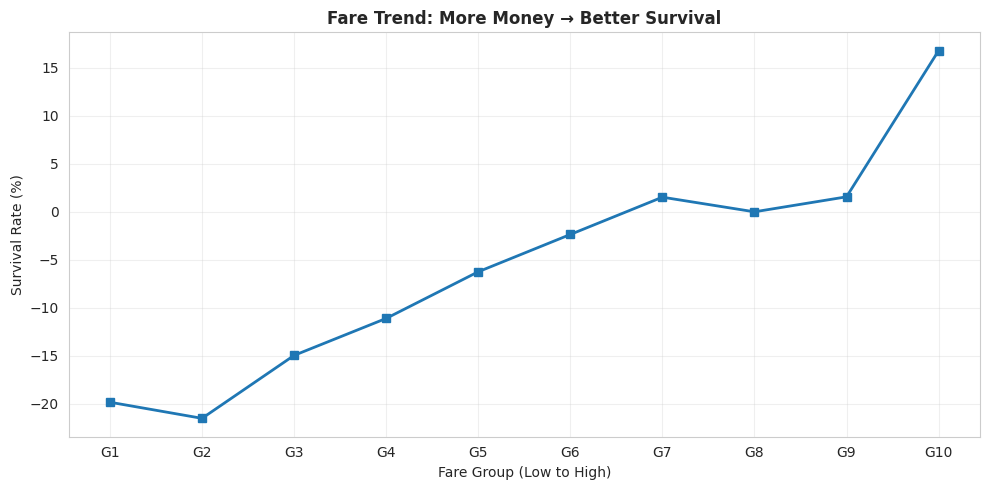

Fare Trend:
Lowest fare group: -19.8% survival
Highest fare group: 16.8% survival


In [17]:
plt.figure(figsize=(10, 5))

train_data['FareGroup'] = pd.qcut(train_data['Fare'], 10)
fare_trend = train_data.groupby('FareGroup')['Survived'].mean()

plt.plot(range(len(fare_trend)), fare_trend.values * 100, marker='s', linewidth=2)
plt.title('Fare Trend: More Money → Better Survival', fontweight='bold')
plt.xlabel('Fare Group (Low to High)')
plt.ylabel('Survival Rate (%)')
plt.xticks(range(len(fare_trend)), [f'G{i+1}' for i in range(len(fare_trend))])
plt.grid(True, alpha=0.3)

plt.annotate('Expensive → Better survival', xy=(7, 70), xytext=(4, 50),
             arrowprops=dict(arrowstyle='->', color='green', lw=2),
             fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("Fare Trend:")
print(f"Lowest fare group: {fare_trend.iloc[0]*100:.1f}% survival")
print(f"Highest fare group: {fare_trend.iloc[-1]*100:.1f}% survival")

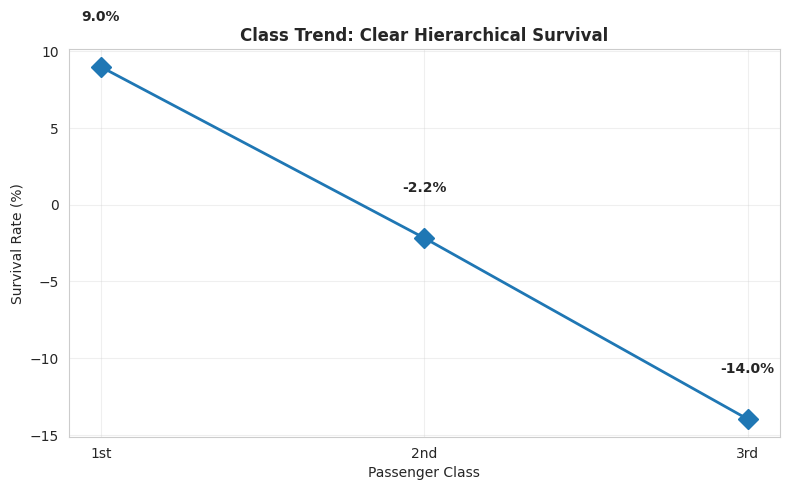

Class Trend: 1st > 2nd > 3rd (always)


In [18]:
plt.figure(figsize=(8, 5))

class_trend = train_data.groupby('Pclass')['Survived'].mean()

plt.plot(['1st', '2nd', '3rd'], class_trend.values * 100, marker='D', linewidth=2, markersize=10)
plt.title('Class Trend: Clear Hierarchical Survival', fontweight='bold')
plt.xlabel('Passenger Class')
plt.ylabel('Survival Rate (%)')
plt.grid(True, alpha=0.3)

for i, value in enumerate(class_trend.values * 100):
    plt.text(i, value + 3, f'{value:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print("Class Trend: 1st > 2nd > 3rd (always)")